# Example A

In this notebook, we will generate all the figures produced regarding Example A in python

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmax, sigmay, sigmaz, sigmam, sigmap, fock_dm, photocurrent_mesolve, expect, steadystate
from FCS import TwoTimeCorrelationSS, PowerSpectrum, FCSPowerSpectrumLinear

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 24})

In [6]:
# Define system parameters
gamma = 1
Omega = 1
Delta = 0
N = 0.2

# Define system operators
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = sigmam()
sp = sigmap()
pe = (1+sz)/2

# Define Hamiltonian, collapse operators, and observable list
H = 0.5 * Delta*sz + Omega*sx
c_ops = [np.sqrt(gamma*(N+1))*sm, np.sqrt(gamma*N)*sp]
e_ops = [pe]

# Define initial states
rho0 = fock_dm(2, 0)
rhoss = steadystate(H, c_ops)
# pess = expect(rhoss, sp*sm)

# Compute energy eigenvalues
eigs = H.eigenenergies()

In [7]:
# Create time array (we are using a large time since we will numerically compute the Power Spectrum too)
tf = 2000
dt = 0.001;
t = np.arange(0, tf, dt)

In [8]:
result = photocurrent_mesolve(H, fock_dm(2,0), t, sc_ops=c_ops, e_ops=e_ops, store_measurement=True, noise=7)

# Get current and expectation value
J = np.real(result.measurement[0].T[0])
pet = result.expect[0]

# Get up and down events from measurement record
pp = np.real(result.measurement[0].T[1])*dt
pm = np.real(result.measurement[0].T[0])*dt

Total run time:  21.36s


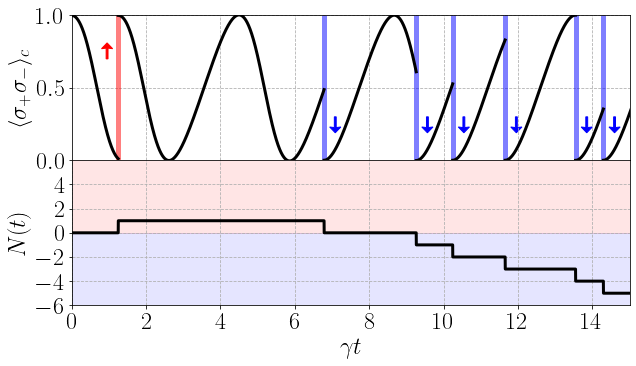

In [10]:
## Create Arrow plot between jumps. Need to get details about jumps

# Compute jump times
tps = t[pp==1]
tms = t[pm==1]

# Specify jump heads and bases of positive and minus process
arrow_headp = np.ones(len(tps))
arrow_headm = np.zeros(len(tms))
arrow_basep = pet[pp==1]
arrow_basem = pet[pm==1]

# Create time windows between jumps
tfi = 15
tvs = np.sort(np.concatenate([tps, tms]))
tvs = tvs
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.04
width = 0.05

# Create figure
fig = plt.figure(figsize=(10, 8))
plt.subplot(3, 1,1)

# Create time windows between jumps
tfi = 15
tvs = np.sort(np.concatenate([tps, tms]))
tvs = tvs
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.04
width = 0.05

# Plot gaps between jumps
for tvi in tvs:
    
    plt.plot(t[(tv0<t)&(t<tvi)], pet[(tv0<t)&(t<tvi)], linewidth=3, color='k', alpha=1)
    tv0 = tvi
    
    if tvi > tfi:
        break
    
# Plot up arraos
for i in range(len(tps)):
    plt.vlines(tps[i], 0, 1, color='r', linewidth=5, alpha=0.5)
    plt.arrow(tps[i]-0.3, 0.7, 0, 0.07, head_width=headw, head_length=headl, width=width, color=[1,0,0], overhang=0.1)

# Plot down arrows
for i in range(len(tms)):
    plt.vlines(tms[i], 0, 1, color='b', linewidth=5, alpha=0.5)
    plt.arrow(tms[i]+0.3, 0.3, 0, -0.07, head_width=headw, head_length=headl, width=width, color=[0,0,1], overhang=0.1)
    

plt.grid(True, linestyle='--')
plt.yticks([0, 0.5, 1])
plt.xticks(np.arange(2, 16, 2))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma_{+}\sigma_{-}\rangle_{c}$')
plt.xlim([0, tfi])
plt.ylim([0,1.0])


plt.subplot(3, 1,2)
plt.plot(t[t<tfi], np.cumsum(pp - pm)[t<tfi], linewidth=3, color='k')
plt.fill_between([0, tf], -7, 0, color='b', alpha=0.1)
plt.fill_between([0, tf], 0, 7, color='r', alpha=0.1)

plt.grid(True, linestyle='--')

plt.xticks(np.arange(0, 18, 2))
plt.yticks(np.arange(-6, 5, 2))
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$ N(t)$')
plt.xlim([0, tfi])
plt.ylim([-6,6])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

# Compute power spectrum and 2 time correlation function

In [15]:
tau = np.linspace(0, 7, 100)
Ftau = TwoTimeCorrelationSS(H, tau, c_ops, rhoss, c_ops, [-1,1], method='PD')

# Average over 20 time steps of raw signal
avg = 20
omegas, S = PowerSpectrum((pp-pm)/dt, dt, avg)

# Compute analytic PS 
omega0 =10
domega = 0.011
omega = np.arange(-omega0, omega0, domega)

# Compute power spectrum
Somega = FCSPowerSpectrumLinear(H, c_ops, rhoss, omega, c_ops, [-1, 1], method='PD')

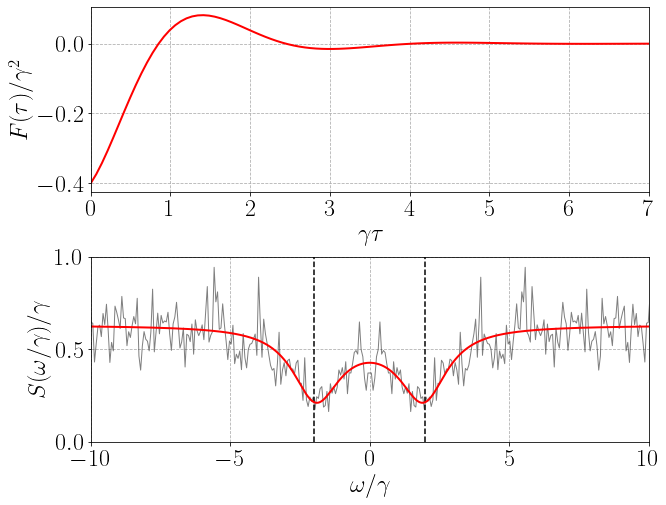

In [16]:
fig = plt.figure(figsize=(10,8))


plt.subplot(2,1,1)
plt.plot(tau, Ftau, color='r', linewidth=2)

plt.xlim([0, 7])
plt.xlabel(r'$\gamma \tau$')
plt.ylabel(r'$F(\tau)/\gamma^{2}$')
plt.grid(True, linestyle='--')

plt.subplot(2,1,2)
plt.plot(omegas, S, color='k', linewidth=1, alpha=0.5)
plt.plot(omega, Somega, color='r', linewidth=2)

plt.vlines(2*eigs[0], 0, 1, linestyle='--', color='k')
plt.vlines(2*eigs[1], 0, 1,  linestyle='--', color='k')
plt.xlim([-10, 10])
plt.ylim([0.0,1])
plt.xticks(np.linspace(-10, 10, 5))
plt.xlabel(r'$\omega/\gamma$')
plt.ylabel(r'$S(\omega/\gamma)/\gamma$')
plt.grid(True, linestyle='--')

plt.subplots_adjust(wspace=0, hspace=0.35)

plt.show()